In [5]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse
import time
from IPython.display import display, clear_output
import sys
import os

# 确保工作目录正确
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# 添加utilities.py所在目录到Python路径
sys.path.append(current_dir)

# 导入utilities.py中的束流处理函数
from utilities import (
    get_image_from_YAG,
    calculate_spot_metrics,
    get_average_YAG_image,
    get_beam_size_from_YAG
)

print("Successfully imported beam processing functions from utilities.py")

# 创建测试光斑生成函数
def generate_test_spot(height=128, width=128, center_x=None, center_y=None, 
                        size_x=20, size_y=15, intensity=10000, noise_level=0.01,
                        elliptical=False, rotation_angle=0):
    """
    生成测试光斑图像
    
    Args:
        height, width: 图像尺寸
        center_x, center_y: 光斑中心位置，如果为None则使用图像中心
        size_x, size_y: 光斑在x和y方向的尺寸（半高全宽的一半）
        intensity: 光斑最大强度
        noise_level: 背景噪声水平 (0-1)
        elliptical: 是否生成椭圆光斑
        rotation_angle: 椭圆旋转角度（弧度）
        
    Returns:
        numpy.ndarray: 生成的光斑图像
    """
    # 创建空白图像
    img = np.zeros((height, width), dtype=np.float32)
    
    # 设置默认中心
    if center_x is None:
        center_x = width // 2
    if center_y is None:
        center_y = height // 2
    
    # 创建网格
    y, x = np.ogrid[:height, :width]
    
    if elliptical:
        # 生成旋转椭圆光斑
        cos_angle = np.cos(rotation_angle)
        sin_angle = np.sin(rotation_angle)
        
        # 旋转坐标系
        x_rot = (x - center_x) * cos_angle + (y - center_y) * sin_angle
        y_rot = -(x - center_x) * sin_angle + (y - center_y) * cos_angle
        
        # 椭圆高斯分布
        gaussian = np.exp(-0.5 * ((x_rot**2)/(size_x**2) + (y_rot**2)/(size_y**2)))
    else:
        # 生成圆形/椭圆形光斑
        gaussian = np.exp(-0.5 * (((x - center_x)**2)/(size_x**2) + ((y - center_y)**2)/(size_y**2)))
    
    # 应用强度
    img = gaussian * intensity
    
    # 添加背景噪声
    if noise_level > 0:
        noise = np.random.normal(0, intensity * noise_level, (height, width))
        img += noise
        img = np.maximum(img, 0)  # 确保没有负值
    
    return img


# 保存测试图像到临时文件，以模拟EPICS获取
def save_test_image_for_epics(img, filename="test_beam_image.npy"):
    """保存图像为numpy格式，模拟EPICS数据"""
    np.save(filename, img.flatten('F'))  # 保存为F顺序的一维数组
    return filename

# 模拟caget函数获取测试图像
def mock_caget(pv):
    """模拟caget函数，用于测试"""
    if pv == "TEST:BEAM:IMAGE":
        # 读取保存的测试图像
        img_data = np.load("test_beam_image.npy")
        return img_data
    elif pv == "TEST:BEAM:GAIN":
        return 0.0
    return None

# 替换utilities中的caget函数
import utilities
utilities.caget = mock_caget

print("Setup mock EPICS functions for testing")

Current working directory: /home/accelerator/ZHANG/beam_size_optimization
Successfully imported beam processing functions from utilities.py
Setup mock EPICS functions for testing


=== Test 1: Standard Circular Spot ===
光斑尺寸 (X方向): 44.00 像素
光斑尺寸 (Y方向): 44.00 像素
光斑质心位置: (64.03, 63.80)
综合尺寸: 62.23 像素


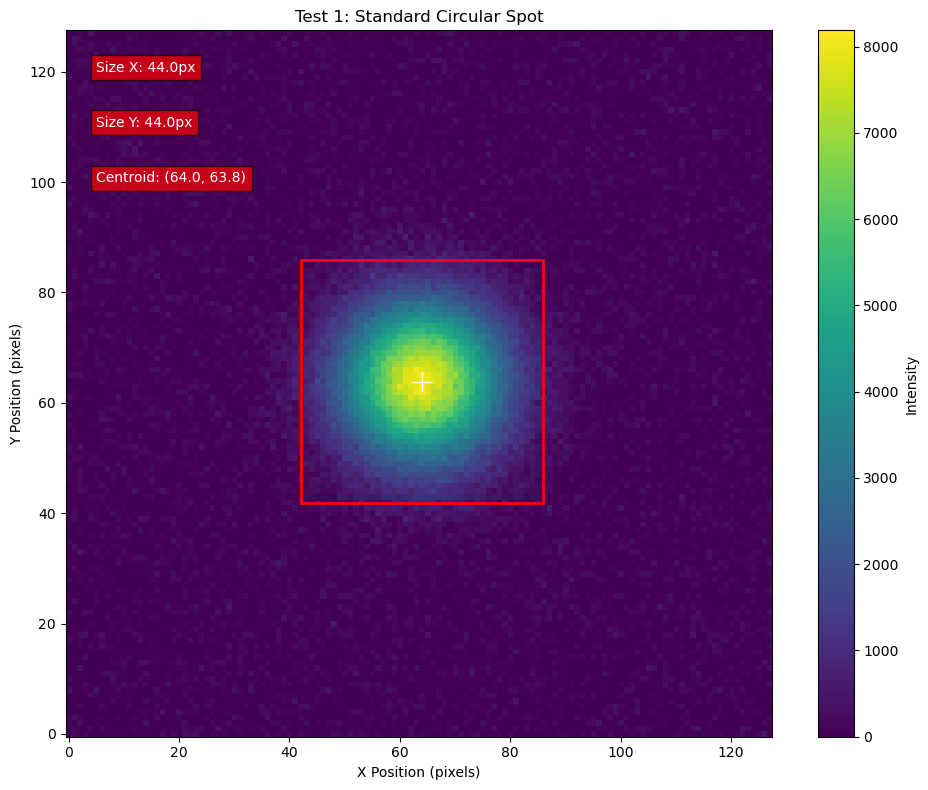

In [9]:
# 测试1：标准圆形光斑
print("=== Test 1: Standard Circular Spot ===")

# 生成测试光斑
test_img1 = generate_test_spot(
    height=128, width=128,
    center_x=64, center_y=64,
    size_x=10, size_y=10,
    intensity=8000,
    noise_level=0.02
)

# 保存为EPICS格式
# save_test_image_for_epics(test_img1)

# 使用utilities函数计算光斑指标
size_x, size_y, centroid_x, centroid_y = calculate_spot_metrics(test_img1, threshold_percent=10)
combined_size = np.sqrt(size_x**2 + size_y**2)

print(f"光斑尺寸 (X方向): {size_x:.2f} 像素")
print(f"光斑尺寸 (Y方向): {size_y:.2f} 像素")
print(f"光斑质心位置: ({centroid_x:.2f}, {centroid_y:.2f})")
print(f"综合尺寸: {combined_size:.2f} 像素")

# 可视化结果
plt.figure(figsize=(10, 8))
plt.imshow(test_img1, cmap='viridis', origin='lower')
plt.colorbar(label='Intensity')

# 绘制光斑边界
x_min = max(0, centroid_x - size_x/2)
x_max = min(127, centroid_x + size_x/2)
y_min = max(0, centroid_y - size_y/2)
y_max = min(127, centroid_y + size_y/2)

# 绘制矩形边界
rect = Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                 linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

# 绘制质心
plt.plot(centroid_x, centroid_y, 'w+', markersize=15, linewidth=2)

# 标注结果
plt.text(5, 120, f"Size X: {size_x:.1f}px", color='white', fontsize=10, 
         bbox=dict(facecolor='red', alpha=0.7))
plt.text(5, 110, f"Size Y: {size_y:.1f}px", color='white', fontsize=10, 
         bbox=dict(facecolor='red', alpha=0.7))
plt.text(5, 100, f"Centroid: ({centroid_x:.1f}, {centroid_y:.1f})", color='white', fontsize=10, 
         bbox=dict(facecolor='red', alpha=0.7))

plt.title('Test 1: Standard Circular Spot')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.tight_layout()
# plt.savefig('test1_circular_spot.png', dpi=150)
plt.show()

=== Test 2: Elliptical Rotated Spot ===
光斑尺寸 (X方向): 111.00 像素
光斑尺寸 (Y方向): 82.00 像素
光斑质心位置: (70.18, 55.05)
综合尺寸: 138.00 像素


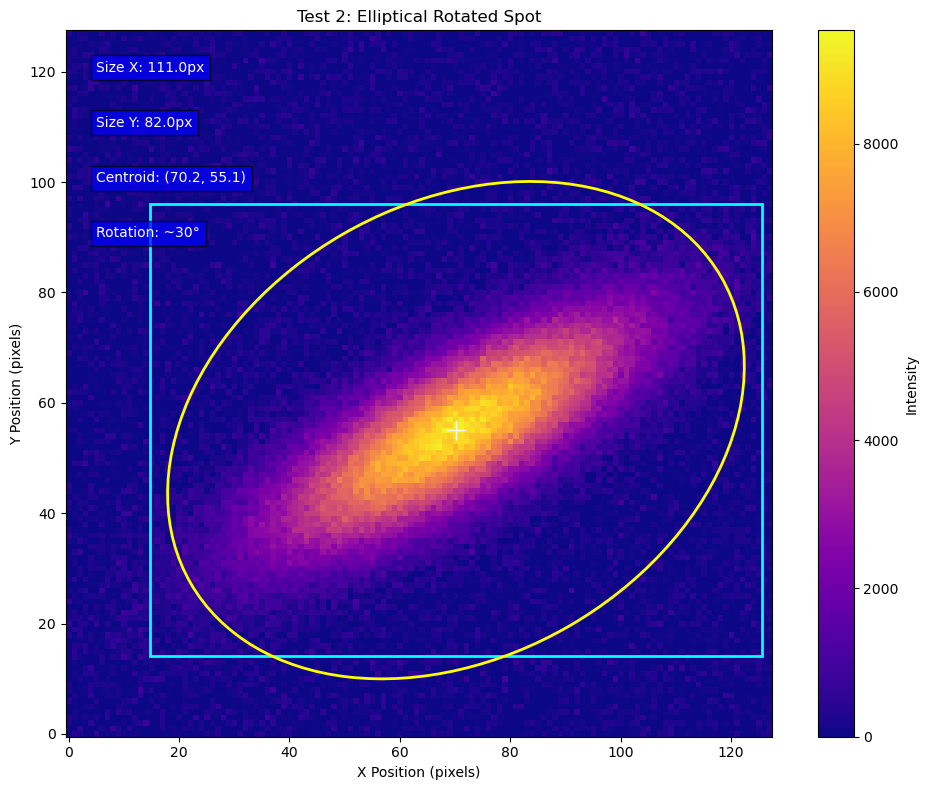

In [ ]:
# 测试2：椭圆光斑，有一定旋转
print("=== Test 2: Elliptical Rotated Spot ===")

# 生成测试光斑
test_img2 = generate_test_spot(
    height=128, width=128,
    center_x=70, center_y=55,
    size_x=25, size_y=8,  # 椭圆形状
    intensity=9000,
    noise_level=0.03,
    elliptical=True,
    rotation_angle=np.pi/6  # 30度旋转
)

# 保存为EPICS格式
# save_test_image_for_epics(test_img2)

# 使用utilities函数计算光斑指标
size_x2, size_y2, centroid_x2, centroid_y2 = calculate_spot_metrics(test_img2, threshold_percent=10)
combined_size2 = np.sqrt(size_x2**2 + size_y2**2)

print(f"光斑尺寸 (X方向): {size_x2:.2f} 像素")
print(f"光斑尺寸 (Y方向): {size_y2:.2f} 像素")
print(f"光斑质心位置: ({centroid_x2:.2f}, {centroid_y2:.2f})")
print(f"综合尺寸: {combined_size2:.2f} 像素")

# 可视化结果
plt.figure(figsize=(10, 8))
plt.imshow(test_img2, cmap='plasma', origin='lower')
plt.colorbar(label='Intensity')

# 绘制光斑边界估计
x_min = max(0, centroid_x2 - size_x2/2)
x_max = min(127, centroid_x2 + size_x2/2)
y_min = max(0, centroid_y2 - size_y2/2)
y_max = min(127, centroid_y2 + size_y2/2)

# 绘制矩形边界
rect = Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                 linewidth=2, edgecolor='cyan', facecolor='none')
plt.gca().add_patch(rect)

# 绘制质心
plt.plot(centroid_x2, centroid_y2, 'w+', markersize=15, linewidth=2)

# 绘制椭圆拟合（近似）
ellipse = Ellipse((centroid_x2, centroid_y2), size_x2, size_y2, 
                  angle=30, edgecolor='yellow', facecolor='none', linewidth=2)
plt.gca().add_patch(ellipse)

# 标注结果
plt.text(5, 120, f"Size X: {size_x2:.1f}px", color='white', fontsize=10, 
         bbox=dict(facecolor='blue', alpha=0.7))
plt.text(5, 110, f"Size Y: {size_y2:.1f}px", color='white', fontsize=10, 
         bbox=dict(facecolor='blue', alpha=0.7))
plt.text(5, 100, f"Centroid: ({centroid_x2:.1f}, {centroid_y2:.1f})", color='white', fontsize=10, 
         bbox=dict(facecolor='blue', alpha=0.7))
plt.text(5, 90, f"Rotation: ~30°", color='white', fontsize=10, 
         bbox=dict(facecolor='blue', alpha=0.7))

plt.title('Test 2: Elliptical Rotated Spot')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.tight_layout()
# plt.savefig('test2_elliptical_rotated_spot.png', dpi=150)
plt.show()

=== Test 3: Off-Center Spot Near Edge ===
光斑尺寸 (X方向): 112.00 像素
光斑尺寸 (Y方向): 121.00 像素
光斑质心位置: (26.33, 91.96)
综合尺寸: 164.88 像素


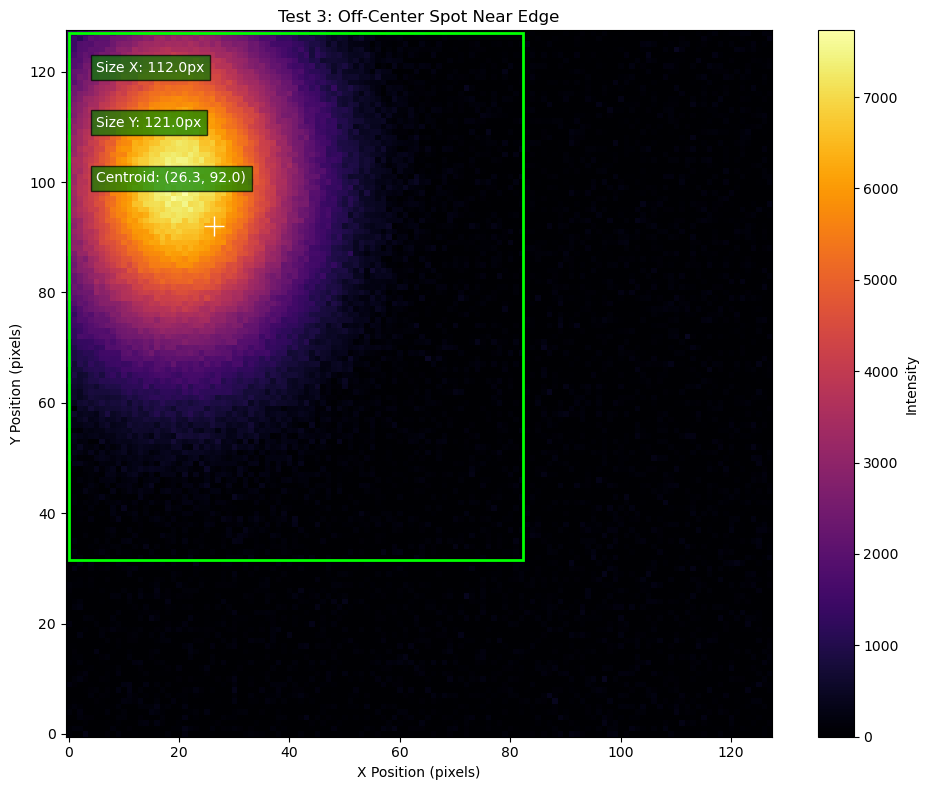

In [11]:
# 测试3：偏心光斑，接近图像边缘
print("=== Test 3: Off-Center Spot Near Edge ===")

# 生成测试光斑
test_img3 = generate_test_spot(
    height=128, width=128,
    center_x=20, center_y=100,  # 接近左下角
    size_x=15, size_y=20,
    intensity=7500,
    noise_level=0.015
)

# 保存为EPICS格式
# save_test_image_for_epics(test_img3)

# 使用utilities函数计算光斑指标
size_x3, size_y3, centroid_x3, centroid_y3 = calculate_spot_metrics(test_img3, threshold_percent=5)
combined_size3 = np.sqrt(size_x3**2 + size_y3**2)

print(f"光斑尺寸 (X方向): {size_x3:.2f} 像素")
print(f"光斑尺寸 (Y方向): {size_y3:.2f} 像素")
print(f"光斑质心位置: ({centroid_x3:.2f}, {centroid_y3:.2f})")
print(f"综合尺寸: {combined_size3:.2f} 像素")

# 可视化结果
plt.figure(figsize=(10, 8))
plt.imshow(test_img3, cmap='inferno', origin='lower')
plt.colorbar(label='Intensity')

# 绘制光斑边界
x_min = max(0, centroid_x3 - size_x3/2)
x_max = min(127, centroid_x3 + size_x3/2)
y_min = max(0, centroid_y3 - size_y3/2)
y_max = min(127, centroid_y3 + size_y3/2)

# 绘制矩形边界
rect = Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                 linewidth=2, edgecolor='lime', facecolor='none')
plt.gca().add_patch(rect)

# 绘制质心
plt.plot(centroid_x3, centroid_y3, 'w+', markersize=15, linewidth=2)

# 标注结果
plt.text(5, 120, f"Size X: {size_x3:.1f}px", color='white', fontsize=10, 
         bbox=dict(facecolor='green', alpha=0.7))
plt.text(5, 110, f"Size Y: {size_y3:.1f}px", color='white', fontsize=10, 
         bbox=dict(facecolor='green', alpha=0.7))
plt.text(5, 100, f"Centroid: ({centroid_x3:.1f}, {centroid_y3:.1f})", color='white', fontsize=10, 
         bbox=dict(facecolor='green', alpha=0.7))

plt.title('Test 3: Off-Center Spot Near Edge')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.tight_layout()
# plt.savefig('test3_offcenter_edge_spot.png', dpi=150)
plt.show()

=== Test 5: Noisy and Disturbed Spot ===


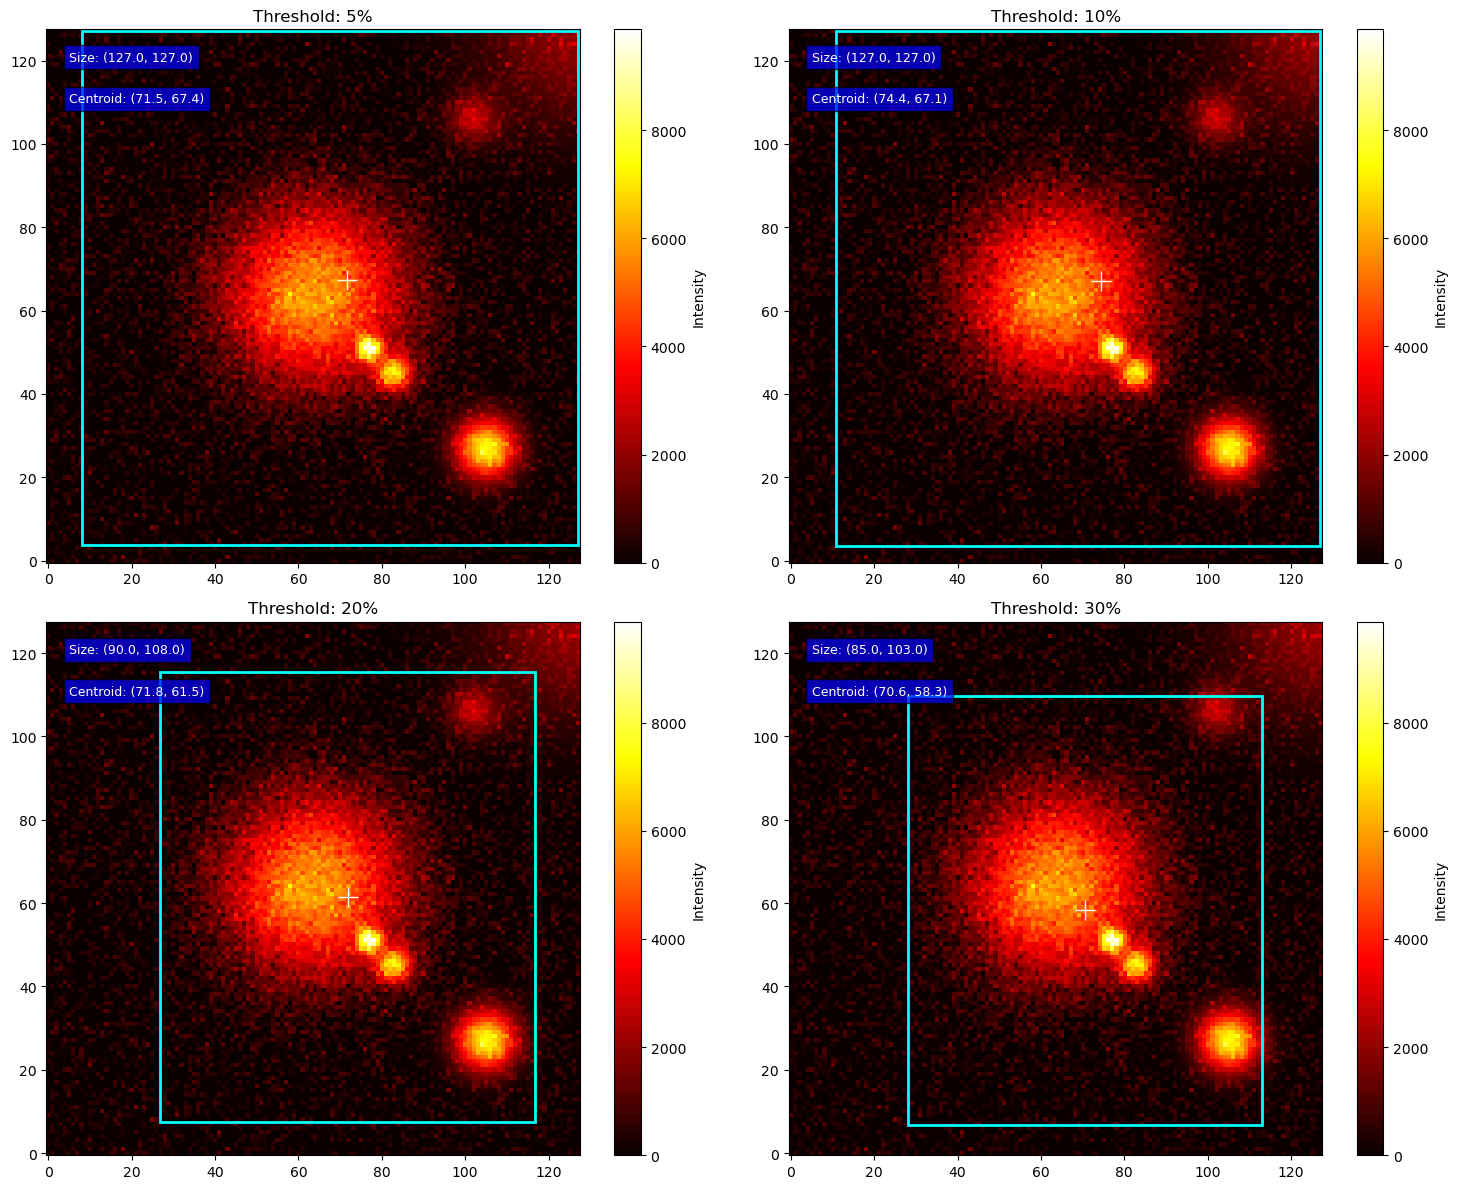


Threshold comparison results:
-----------------------------------------------------------------
Threshold (%)   Size X (px)     Size Y (px)     Centroid X      Centroid Y     
-----------------------------------------------------------------
5               127.00          127.00          71.54           67.38          
10              127.00          127.00          74.37           67.14          
20              90.00           108.00          71.81           61.46          
30              85.00           103.00          70.61           58.26          
-----------------------------------------------------------------

Selected threshold 10% gives reliable measurements


In [12]:
# 测试5：噪声和干扰情况
print("=== Test 5: Noisy and Disturbed Spot ===")

# 生成带有额外干扰的光斑
def generate_noisy_spot_with_interference(height=128, width=128):
    """生成带有噪声和干扰的光斑"""
    # 基础光斑
    img = generate_test_spot(
        height=height, width=width,
        center_x=64, center_y=64,
        size_x=15, size_y=15,
        intensity=6000,
        noise_level=0.08
    )
    
    # 添加随机火花/热点干扰
    num_sparks = np.random.randint(3, 8)
    for _ in range(num_sparks):
        spark_x = np.random.randint(0, width)
        spark_y = np.random.randint(0, height)
        spark_size = np.random.randint(2, 6)
        spark_intensity = np.random.uniform(2000, 8000)
        
        # 创建火花
        y, x = np.ogrid[:height, :width]
        spark = np.exp(-0.5 * (((x-spark_x)**2 + (y-spark_y)**2) / (spark_size**2)))
        img += spark * spark_intensity
    
    # 添加背景梯度
    y, x = np.ogrid[:height, :width]
    background_gradient = np.exp(-0.002 * ((x-128)**2 + (y-128)**2)) * 2000
    img += background_gradient
    
    # 确保没有负值
    img = np.maximum(img, 0)
    
    return img

# 生成噪波光斑
test_img5 = generate_noisy_spot_with_interference()
# save_test_image_for_epics(test_img5)

# 测试不同阈值的效果
thresholds = [5, 10, 20, 30]
results = []

plt.figure(figsize=(15, 12))

for i, threshold in enumerate(thresholds):
    size_x5, size_y5, centroid_x5, centroid_y5 = calculate_spot_metrics(test_img5, threshold_percent=threshold)
    combined_size5 = np.sqrt(size_x5**2 + size_y5**2)
    
    results.append((threshold, size_x5, size_y5, centroid_x5, centroid_y5, combined_size5))
    
    plt.subplot(2, 2, i+1)
    plt.imshow(test_img5, cmap='hot', origin='lower')
    plt.colorbar(label='Intensity')
    
    # 绘制计算的边界
    if np.isfinite(size_x5) and np.isfinite(size_y5):
        x_min = max(0, centroid_x5 - size_x5/2)
        x_max = min(127, centroid_x5 + size_x5/2)
        y_min = max(0, centroid_y5 - size_y5/2)
        y_max = min(127, centroid_y5 + size_y5/2)
        
        rect = Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                        linewidth=2, edgecolor='cyan', facecolor='none')
        plt.gca().add_patch(rect)
        plt.plot(centroid_x5, centroid_y5, 'w+', markersize=15, linewidth=2)
    
    plt.title(f'Threshold: {threshold}%')
    plt.text(5, 120, f"Size: ({size_x5:.1f}, {size_y5:.1f})", color='white', fontsize=9, 
            bbox=dict(facecolor='blue', alpha=0.7))
    plt.text(5, 110, f"Centroid: ({centroid_x5:.1f}, {centroid_y5:.1f})", color='white', fontsize=9, 
            bbox=dict(facecolor='blue', alpha=0.7))

plt.tight_layout()
# plt.savefig('test5_threshold_comparison.png', dpi=150)
plt.show()

# 显示结果表格
print("\nThreshold comparison results:")
print("-" * 65)
print(f"{'Threshold (%)':<15} {'Size X (px)':<15} {'Size Y (px)':<15} {'Centroid X':<15} {'Centroid Y':<15}")
print("-" * 65)
for threshold, sx, sy, cx, cy, _ in results:
    if np.isfinite(sx) and np.isfinite(sy):
        print(f"{threshold:<15} {sx:<15.2f} {sy:<15.2f} {cx:<15.2f} {cy:<15.2f}")
    else:
        print(f"{threshold:<15} {'INVALID':<15} {'INVALID':<15} {'INVALID':<15} {'INVALID':<15}")
print("-" * 65)

# 选择最佳阈值（这里选择10%）
best_threshold = 10
best_size_x5, best_size_y5, best_cx5, best_cy5 = calculate_spot_metrics(test_img5, threshold_percent=best_threshold)
print(f"\nSelected threshold {best_threshold}% gives reliable measurements")